# Training a Fully Convolutional Network for Brain Tumor Segmentation

In [13]:
import SimpleITK as sitk
import os
import h5py
import numpy as np
import matplotlib

import tensorflow as tf
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print("autoscrolling long output is disabled")

disable_scroll()

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [14]:
data_path = './'

### Get the processed data

In [15]:
data = h5py.File(data_path+'brats_train.h5', 'r')
data_test = h5py.File(data_path+'brats_test.h5', 'r')

X_p_train = data['X_positive']
Y_p_train = data['Y_positive']
X_n_train = data['X_negative']
Y_n_train = data['Y_negative']
print(np.amax(Y_p_train))
print('X_p_train shape = {}\nY_p_train shape = {}\nX_n_train shape = {}\nY_n_train shape = {}'.format(X_p_train.shape, Y_p_train.shape, X_n_train.shape,Y_n_train.shape))

X_p_test = data_test['X_positive']
Y_p_test = data_test['Y_positive']
X_n_test = data_test['X_negative']
Y_n_test = data_test['Y_negative']
print('X_p_test shape = {}\nY_p_test shape = {}\nX_n_test shape = {}\nY_n_test shape = {}'.format(X_p_test.shape, Y_p_test.shape, X_n_test.shape, Y_n_test.shape))

4.0
X_p_train shape = (14622, 128, 128)
Y_p_train shape = (14622, 128, 128)
X_n_train shape = (16378, 128, 128)
Y_n_train shape = (16378, 128, 128)
X_p_test shape = (1474, 128, 128)
Y_p_test shape = (1474, 128, 128)
X_n_test shape = (1626, 128, 128)
Y_n_test shape = (1626, 128, 128)


### Tensorflow funtion

We will train a convolutional network and use the leaky relu activation funtion.
We use conv2D and conv_block

In [16]:
def leaky_relu(x):
    return tf.maximum(0.2*x,x)

def conv2D(x, dims=[3, 3], filters=32, strides=[1, 1],
           std=1e-3, padding='SAME', activation=tf.identity, scope='conv2d'):
  """
  args:
      x, (tf tensor), tensor with shape (batch,width,height,channels)
      dims, (list), size of convolution filters
      filters, (int), number of filters used
      strides, (list), number of steps convolutions slide
      std, (float/string), std of weight initialization, 'xavier' for xavier
          initialization
      padding, (string), 'SAME' or 'VALID' determines if input should be padded
          to keep output dimensions the same or not
      activation, (tf function), tensorflow activation function, e.g. tf.nn.relu
      scope, (string), scope under which to store variables
  returns:
      a, (tf tensor), the output of the convolution layer, has size
          (batch, new_width , new_height , filters)
  """
  with tf.variable_scope(scope):
    s = x.get_shape().as_list()

    shape = dims + [s[3], filters]

    if std == 'xavier':
      std = np.sqrt(2.0 / (s[1] * s[2] * s[3]))

    W = tf.Variable(tf.random_normal(shape=shape, stddev=std), name='W')

    b = tf.Variable(tf.ones([filters]) * std, name='b')

    o = tf.nn.convolution(x, W, padding, strides=strides)

    o = o + b

    a = activation(o)

    return a

def conv_block(x,dims=[5,5],filters=16,num_layers=5,activation=tf.identity,scope='conv_block'):
    o = x
    with tf.variable_scope(scope):
        for i in range(1,num_layers):
            scope = 'conv_{}'.format(i)
            o = conv2D(o,dims=dims,filters=filters,std=std,activation=act, scope=scope)
    return o

def get_batch(Xp,Yp, Xn, Yn, n=32):
    Np = Xp.shape[0]
    Nn = Xn.shape[0]
    
    inds_p = sorted(np.random.choice(range(Np),size=n, replace=False))
    inds_n = sorted(np.random.choice(range(Nn),size=n, replace=False))
    
    xp = Xp[inds_p,:,:]
    yp = Yp[inds_p,:,:]
    
    xn = Xn[inds_n]
    yn = Yn[inds_n]
    
    x = np.concatenate((xp,xn))
    y = np.concatenate((yp,yn))
    
    x = x[:,:,:,np.newaxis].astype(np.float32)
    return x,y

### Network parameters

In [38]:
train_steps = 10000
Nbatch = 16
print_step = 200

W = X_p_train.shape[1]
H = W
C = 1

num_layers = 5
filters = 32
dims = [7,7]
strides = [1,1]

act = leaky_relu

std=1e-2
num_classes=5
learning_rate=1e-3

class_weights= np.asarray([1.0, 60.0, 20.0, 80.0, 80.0])
# class_weights = class_weights/np.sum(class_weights)

### Tensorflow graph construction

In [39]:
x = tf.placeholder(shape=[None,W,H,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,W,H],dtype=tf.int32)

y_truth = tf.one_hot(y,depth=num_classes,axis=3)

#####################################
# Convolutional part
#####################################
o = conv_block(x,dims,filters,num_layers,act,scope="conv_block_1")

o = conv2D(o,dims=dims,filters=num_classes,strides=strides,std=std,
           activation=tf.identity, scope='conv_final')

yhat = tf.nn.softmax(o)

l_temp = tf.reduce_mean(-y_truth*tf.log(yhat+1e-5),axis=[0,1,2])

l_temp = l_temp*class_weights

loss = tf.reduce_mean(l_temp)

### Optimizer

In [40]:
opt = tf.train.AdamOptimizer(learning_rate)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

In [41]:
sess = tf.Session()
sess.run(init)

### Training loop

In [42]:
#Start the train loop
train_hist = []
val_hist = []

for i in range(train_steps):
    xb,yb = get_batch(X_p_train,Y_p_train,X_p_train,Y_p_train,n=Nbatch)
    l,_=sess.run([loss,train],{x:xb,y:yb})

    if i%print_step == 0:
        xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)
        lval=sess.run(loss,{x:xb,y:yb})
        print("iter: {} Train: {} Val: {}".format(i,l,lval))
        train_hist.append(l)
        val_hist.append(lval)

iter: 0 Train: 1.1917022466659546 Val: 0.9758397936820984
iter: 200 Train: 1.2782986164093018 Val: 0.6432486772537231
iter: 400 Train: 1.0124562978744507 Val: 0.7864576578140259
iter: 600 Train: 0.9259872436523438 Val: 1.1540319919586182
iter: 800 Train: 1.1489132642745972 Val: 0.7454115748405457
iter: 1000 Train: 0.9481664896011353 Val: 0.8777838945388794
iter: 1200 Train: 0.8732770681381226 Val: 0.8541101217269897
iter: 1400 Train: 1.0199816226959229 Val: 1.1587947607040405
iter: 1600 Train: 1.005985975265503 Val: 0.6566625833511353
iter: 1800 Train: 1.1793607473373413 Val: 0.6323236227035522
iter: 2000 Train: 1.1248713731765747 Val: 0.7014567255973816
iter: 2200 Train: 1.0800693035125732 Val: 0.6339153051376343
iter: 2400 Train: 0.991185188293457 Val: 0.3780236840248108
iter: 2600 Train: 1.0177446603775024 Val: 0.8765053749084473


KeyboardInterrupt: 

### Loss Curves

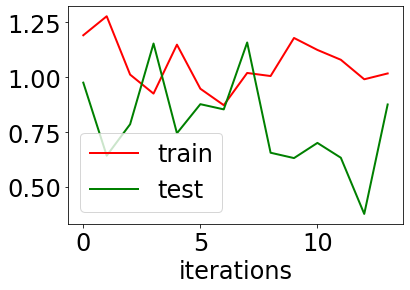

In [43]:
plt.figure()
plt.plot(train_hist,color='r',linewidth=2,label='train')
plt.plot(val_hist,color='g',linewidth=2,label='test')
plt.xlabel('iterations')
plt.legend()
plt.show()

### Neural Network Predictions

<Figure size 432x288 with 0 Axes>

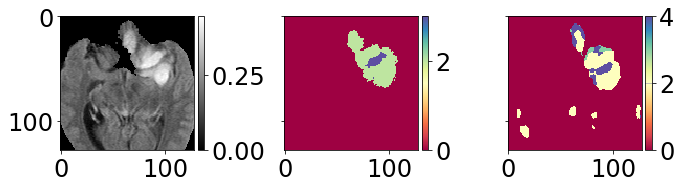

<Figure size 432x288 with 0 Axes>

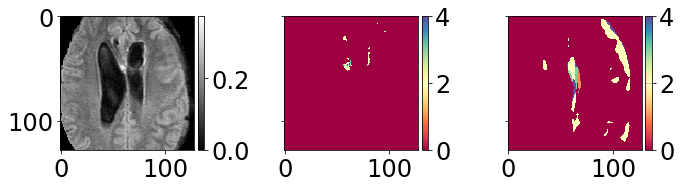

<Figure size 432x288 with 0 Axes>

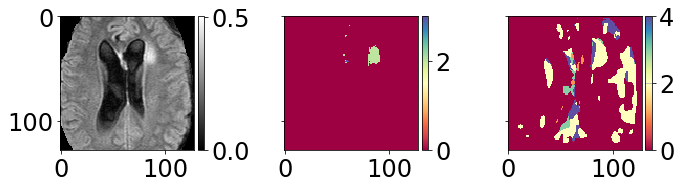

<Figure size 432x288 with 0 Axes>

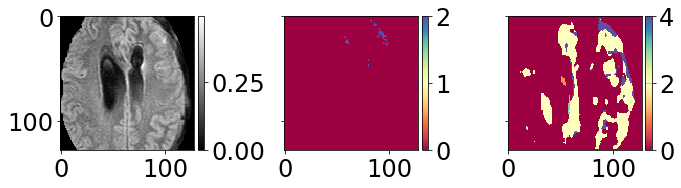

<Figure size 432x288 with 0 Axes>

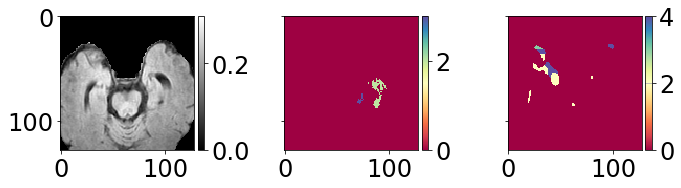

<Figure size 432x288 with 0 Axes>

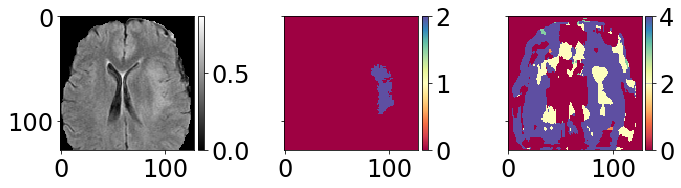

<Figure size 432x288 with 0 Axes>

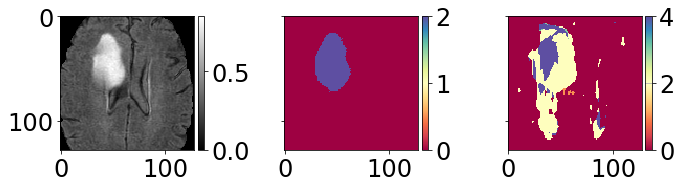

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def implot(mp,ax,cmap='gray'):
    im = ax.imshow(mp.astype(np.float32), cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)

    
xb,yb = get_batch(X_p_test,Y_p_test,X_n_test,Y_n_test,n=Nbatch)

yh = sess.run(yhat,{x:xb})

ypred = np.argmax(yh,axis=3)

for i in range(7):
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(10,3))
    implot(xb[i,:,:,0],ax1)
    implot(yb[i,:,:],ax2,cmap='Spectral')
    implot(ypred[i,:,:],ax3,cmap='Spectral')
    plt.grid('off')
    plt.tight_layout()
    plt.savefig('images_{}.pdf'.format(i),dpi=600)
    plt.show()